In [1]:
import numpy as np
import pandas as pd
import json
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from plotnine import *

In [2]:
d = pd.read_csv('rank_runs_summary.csv')

d

,example_name,estimate_name,SpearmanR_all,SpearmanR_test,pick_auc_test,pick_KL_div_test,training_lists,test_lists,data_size,test_size,extra_info,score_name,p_continue,generative_noise_scale,scoring_noise_scale,run_i,rand_seed
0,uci wine example,Stan inspection model,0.602680,0.599536,0.731827,0.964698,100,2000,6497,6017,"{""est_p_continue"": 0.7342969907500001}",quality,0.8,0.87,2.0,0,518677876
1,uci wine example,Stan list utility model,0.631550,0.629381,0.743813,0.782143,100,2000,6497,6017,NaN,quality,0.8,0.87,2.0,0,518677876
2,uci wine example,Stan difference utility model,0.621062,0.619063,0.736803,0.863267,100,2000,6497,6017,NaN,quality,0.8,0.87,2.0,0,518677876
3,uci wine example,"logistic differences, early stop=T",0.482493,0.482534,0.725415,0.424981,100,2000,6497,6017,NaN,quality,0.8,0.87,2.0,0,518677876
4,uci wine example,"logistic differences, early stop=F",0.632136,0.630633,0.749933,0.398092,100,2000,6497,6017,NaN,quality,0.8,0.87,2.0,0,518677876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,uci wine example,Stan difference utility model,0.673102,0.673645,0.741306,0.967363,100,2000,6497,6014,NaN,quality,0.8,0.87,2.0,19,364254565
136,uci wine example,"logistic differences, early stop=T",0.637675,0.636223,0.754824,0.387336,100,2000,6497,6014,NaN,quality,0.8,0.87,2.0,19,364254565
137,uci wine example,"logistic differences, early stop=F",0.672575,0.673168,0.763472,0.388014,100,2000,6497,6014,NaN,quality,0.8,0.87,2.0,19,364254565
138,uci wine example,logistic items,0.685498,0.685709,0.761882,0.382413,100,2000,6497,6014,NaN,quality,0.8,0.87,2.0,19,364254565


In [3]:
n_draws = int(np.max(d['run_i']) + 1)
n_lists = int(np.mean(d['training_lists']))

In [4]:
d_SpearmanR = d.loc[:, ['estimate_name', 'pick_auc_test', 'SpearmanR_test']].reset_index(drop=True, inplace=False)
d_SpearmanR['is_Stan_model'] = [nm.startswith('Stan ') for nm in d_SpearmanR['estimate_name']]
ideal_score = d_SpearmanR.loc[d_SpearmanR['estimate_name'] == 'observed score', 'SpearmanR_test'].mean()
d_SpearmanR = d_SpearmanR.loc[d_SpearmanR['estimate_name'] != 'observed score', :]

d_SpearmanR

,estimate_name,pick_auc_test,SpearmanR_test,is_Stan_model
0,Stan inspection model,0.731827,0.599536,True
1,Stan list utility model,0.743813,0.629381,True
2,Stan difference utility model,0.736803,0.619063,True
3,"logistic differences, early stop=T",0.725415,0.482534,False
4,"logistic differences, early stop=F",0.749933,0.630633,False
...,...,...,...,...
134,Stan list utility model,0.746316,0.680578,True
135,Stan difference utility model,0.741306,0.673645,True
136,"logistic differences, early stop=T",0.754824,0.636223,False
137,"logistic differences, early stop=F",0.763472,0.673168,False


In [5]:
model_breaks = [
    'Stan inspection model',
    'Stan list utility model',
    'Stan difference utility model',
    'logistic differences, early stop=T',
    'logistic differences, early stop=F',
    'logistic items',
]
model_labels = [
    'Stan sequential inspection',
    'Stan list utility',
    'Stan pair utility',
    'logistic differences, early stop',
    'logistic differences',
    'logistic items',
]

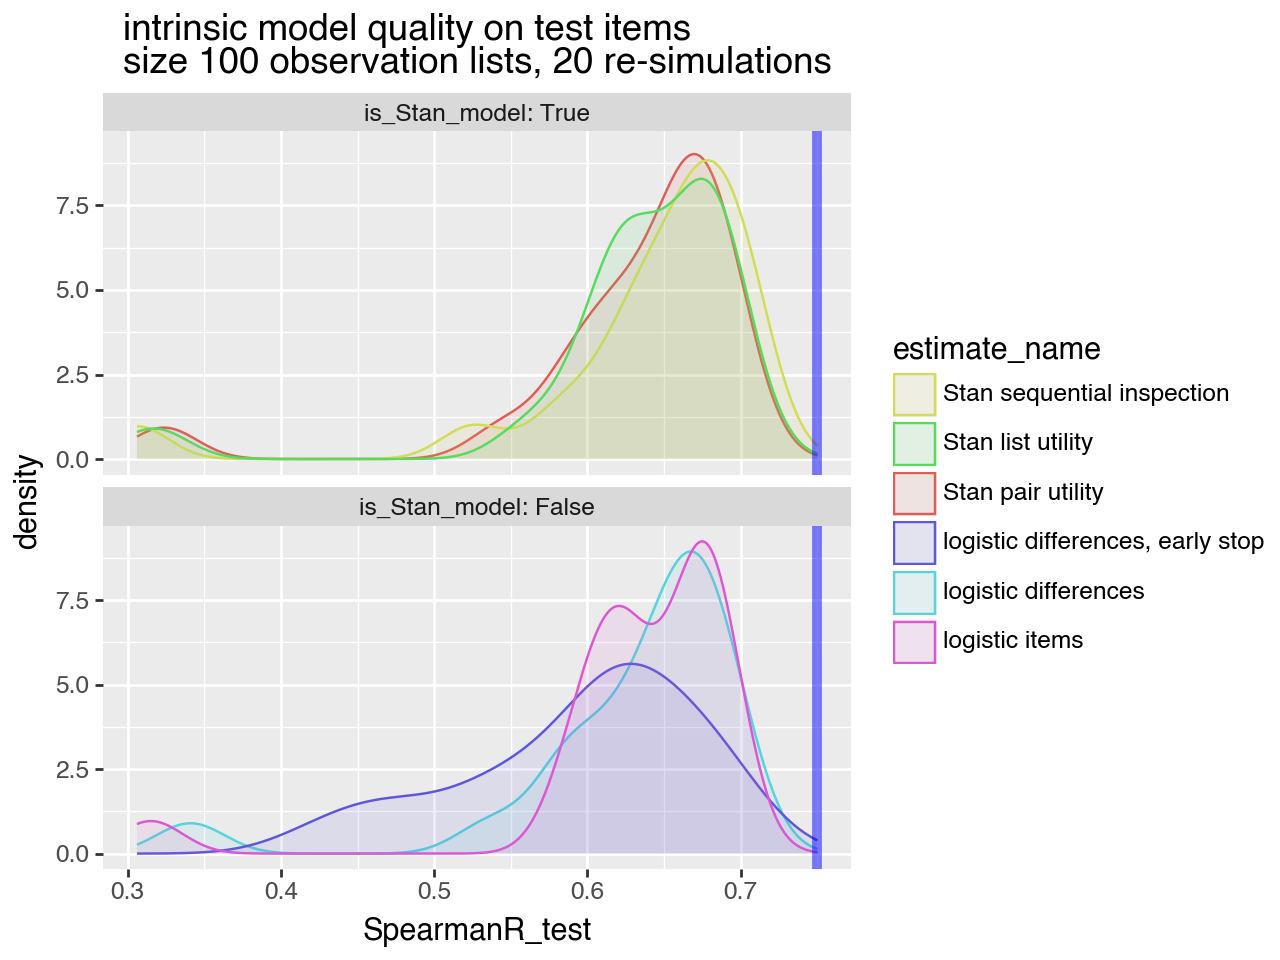

In [6]:
(
    ggplot(
        data=d_SpearmanR,
        mapping=aes(
            x='SpearmanR_test',
            color='estimate_name',
            fill='estimate_name',
        )
    )
    + facet_wrap(
        'is_Stan_model', 
        ncol=1, 
        labeller='label_both',
        as_table=False,
        )
    + geom_density(alpha=0.1)
    + scale_color_discrete(breaks=model_breaks, labels=model_labels)
    + scale_fill_discrete(breaks=model_breaks, labels=model_labels)
    + geom_vline(xintercept=ideal_score, color='blue', alpha=0.5, size=2)
    + ggtitle(f"intrinsic model quality on test items\nsize {n_lists} observation lists, {n_draws} re-simulations")
)

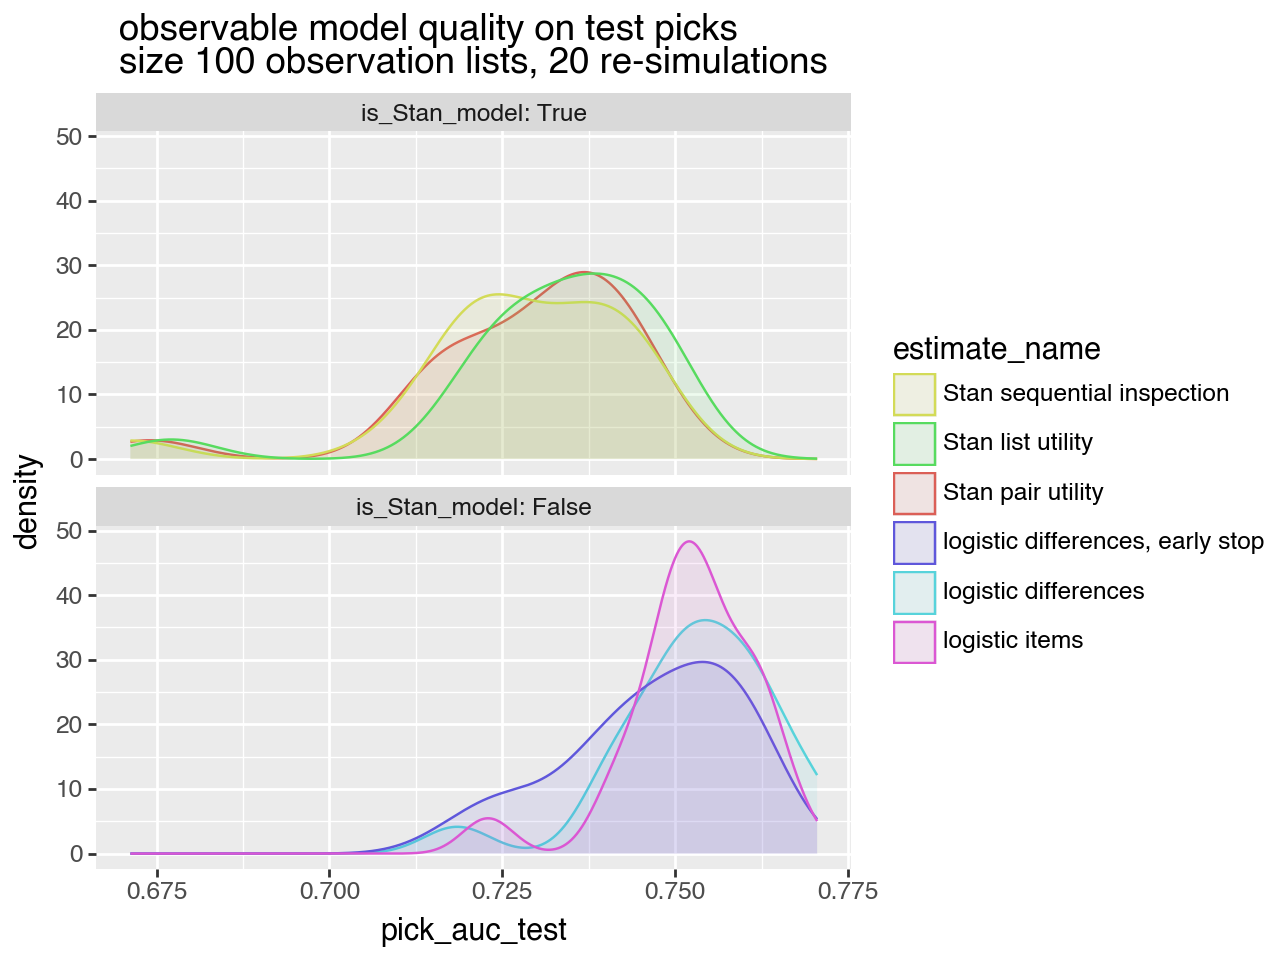

In [7]:

(
    ggplot(
        data=d_SpearmanR,
        mapping=aes(
            x='pick_auc_test',
            color='estimate_name',
            fill='estimate_name',
        )
    )
    + facet_wrap(
        'is_Stan_model', 
        ncol=1, 
        labeller='label_both',
        as_table=False,
        )
    + geom_density(alpha=0.1)
    + scale_color_discrete(breaks=model_breaks, labels=model_labels)
    + scale_fill_discrete(breaks=model_breaks, labels=model_labels)
    + ggtitle(f"observable model quality on test picks\nsize {n_lists} observation lists, {n_draws} re-simulations")
)

In [8]:
de = d.loc[d['estimate_name'] == 'Stan inspection model', ['test_lists', 'extra_info']].reset_index(drop=True, inplace=False)
de['est_p_continue'] = [json.loads(v)['est_p_continue'] for v in de['extra_info']]
de.head()

,test_lists,extra_info,est_p_continue
0,2000,"{""est_p_continue"": 0.7342969907500001}",0.734297
1,2000,"{""est_p_continue"": 0.78037406875}",0.780374
2,2000,"{""est_p_continue"": 0.77916347}",0.779163
3,2000,"{""est_p_continue"": 0.75079047725}",0.750790
4,2000,"{""est_p_continue"": 0.73228057975}",0.732281


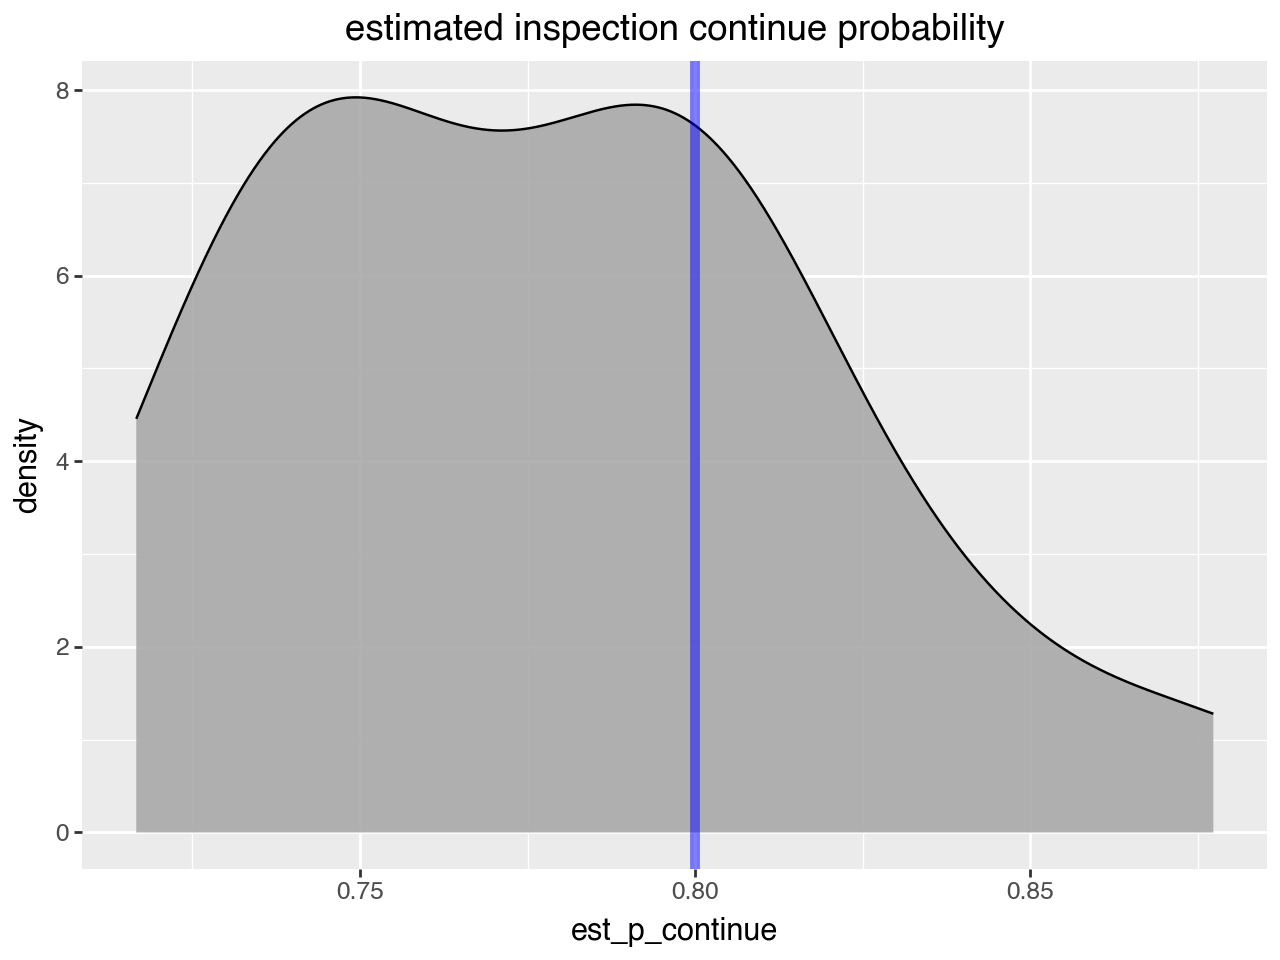

In [9]:
(
    ggplot(
        data=de,
        mapping=aes(x='est_p_continue')
    )
    + geom_density(fill='darkgrey', alpha=0.9)
    + geom_vline(xintercept=np.mean(d['p_continue']), color='blue', size=2, alpha=0.5)
    + ggtitle("estimated inspection continue probability")
)

